#### MIT License (c) 2017 by Andrew Lyasoff

#### Jupyter notebook written in the Julia 0.6.2. It implements the numerical program for computing the exercise boundary of an American-style call option described in Sec. 18.4 of my book "Stochastic Methods in Asset Pricing" (pp. 514-516). The same program is implemented in Python in Appendix B.3 of the book. The present implementation uses 4 parallel processes and is only marginally faster than the implementation on a single process (which is about 4 times faster than the implementation in Python given in the book).

In [1]:
addprocs(4);

In [2]:
@everywhere using SpecialFunctions
@everywhere K=40;
@everywhere σ=3/10;
@everywhere δ=7/100;
@everywhere r=2/100;
@everywhere T=1/2;
@everywhere using Interpolations

In [3]:
@everywhere function ix(n::Number)
    lcl=[(n-1)*1250+1,n*1250]
    return lcl
end

## Initialize the procedure

In [4]:
@everywhere Δ=T/5000
absc=0.0:Δ:T;
val=[max(K,K*(r/δ)) for x in absc];
itp = interpolate(val, BSpline(Cubic(Natural())), OnGrid());
f=scale(itp,absc);
#f=t->fi[t];
EC=(S,t,K,σ,r,δ)->(1/2)*sqrt(pi)*((erf(1/4*sqrt(2)*((σ^2 - 2*δ + 2*r)*t - 2*log(K/S))/(σ*sqrt(t)))*exp(-(δ - r)*t) + exp(-(δ - r)*t))*S + K*erf(1/4*sqrt(2)*((σ^2 + 2*δ - 2*r)*t + 2*log(K/S))/(σ*sqrt(t))) - K)*sqrt(t)*exp(-r*t)/sqrt(pi*t);
F=(ϵ,t,u,v,r,δ,σ)-> erf(ϵ/4*sqrt(2)*σ*sqrt(-t + u)-(1/2)*sqrt(2)*δ*sqrt(-t + u)/σ + (1/2)*sqrt(2)*r*sqrt(-t + u)/σ - (1/2)*sqrt(2)*log(v)/(σ*sqrt(-t + u)))+1;
ah=(t,z)->(exp(-δ*(z-t))*(δ/2)*F(1,t,z,f[z]/f[t],r,δ,σ));
bh=(t,z)->(exp(-r*(z-t))*(r*K/2)*F(-1,t,z,f[z]/f[t],r,δ,σ));
for i=2:5
    remotecall_fetch(()->f, i)
    remotecall_fetch(()->EC, i)
    remotecall_fetch(()->F, i)
    remotecall_fetch(()->ah, i)
    remotecall_fetch(()->bh, i)
end

N.B.: $\int_a^bf(t)dt={1\over2}(b-a)\int_{-1}^{+1}f\bigl({1\over2}(b-a)s+{1\over2}(a+b)\bigr)d s$

In [5]:
@everywhere using Roots
@everywhere using FastGaussQuadrature
@everywhere nodes,weights=gausslegendre( 200 );

## Define the function to call in each separate process

In [6]:
@everywhere function mainF()
    bounds=ix(myid()-1)
    loc=[]
    for j=bounds[1]:1:bounds[2]
        ttt=(j-1)*Δ
        an=map(s->(1/2)*(T-ttt)*ah(ttt,(1/2)*(T-ttt)*s+(1/2)*(ttt+T)),nodes);
        bn=map(s->(1/2)*(T-ttt)*bh(ttt,(1/2)*(T-ttt)*s+(1/2)*(ttt+T)),nodes);
        aaa=dot(weights,an);
        bbb=dot(weights,bn);
        LRT=fzero(x->x-K-EC(x,T-ttt,K,σ,r,δ)-aaa*x+bbb,K-1,K+15);
        loc=vcat(loc,[LRT])
    end
    return loc
end

## Now perform the iterations, splitting the work in every iteration among the 4 processes.

In [7]:
@time for iter=1:10
    lst=[@spawnat i mainF() for i=2:5];
    val0=[fetch(lst[i]) for i=1:4];
    val=[];
    for i=1:length(val0)
        val=vcat(val,val0[i]);
    end
    val=vcat(val,[max(K,K*(r/δ))]);
    zval=[val[i] for i=1:length(val)];
    itp=interpolate(zval, BSpline(Cubic(Natural())), OnGrid());
    f=scale(itp,absc);
    ah=(t,z)->(exp(-δ*(z-t))*(δ/2)*F(1,t,z,f[z]/f[t],r,δ,σ));
    bh=(t,z)->(exp(-r*(z-t))*(r*K/2)*F(-1,t,z,f[z]/f[t],r,δ,σ));
    for i=2:5
        remotecall_fetch(()->f, i)
        remotecall_fetch(()->ah, i)
        remotecall_fetch(()->bh, i)
    end
end     

  6.726653 seconds (529.70 k allocations: 35.926 MiB, 0.07% gc time)


## Illustrate the result

In [8]:
using PyPlot

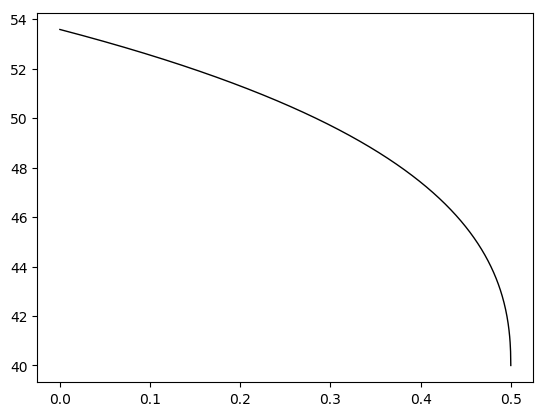

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3305c1cd10>

In [9]:
ff=t->f[t]
x = linspace(0.0,0.5,2000)
y = ff.(x)
plot(x, y, "k-", linewidth=1)